# Random Forest

In [ ]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loade data
df = pd.read_csv('/content/drive/MyDrive/train_data.csv')

df

title   outlet  label
0     Jack Carr recalls Gen. Eisenhower's D-Day memo...  FoxNews      1
1     Bruce Willis, Demi Moore avoided doing one thi...  FoxNews      1
2     Blinken meets Qatar PM, says Israeli actions a...  FoxNews      1
3     Emily Blunt says her ‘toes curl’ when people t...  FoxNews      1
4     'The View' co-host, CNN commentator Ana Navarr...  FoxNews      1
...                                                 ...      ...    ...
3784  Trump's lawyers seek post-Election Day delay f...      NBC      0
3785  How to treat acne scars and hyperpigmentation,...      NBC      0
3786  7 best vegetarian and vegan meal delivery serv...      NBC      0
3787  Trump says presidential civilian award is 'bet...      NBC      0
3788  19 best white elephant and Secret Santa gift i...      NBC      0

[3789 rows x 3 columns]

In [ ]:
# Extract features and lables
X = df['title']
y = df['label']

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to convert text data into BERT embeddings
def get_bert_embeddings(texts, tokenizer, model):
    """
    Generate BERT embeddings for a list of texts.
    Args:
        texts (list): List of text strings.
        tokenizer: Hugging Face tokenizer.
        model: Hugging Face BERT model.
    Returns:
        np.array: Embeddings for each text input.
    """
    embeddings = []
    for text in texts:
        # Tokenize and encode the text
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

        # Get the BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the [CLS] token embedding as the sentence-level embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)
        embeddings.append(cls_embedding.numpy())

    return embeddings

# Generate BERT embeddings for the entire dataset
print("Generating BERT embeddings...")
X_embeddings = get_bert_embeddings(X, tokenizer, model)

# Convert embeddings to NumPy array
import numpy as np
X_embeddings = np.array(X_embeddings)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generating BERT embeddings...


In [ ]:
# Remove unimportant words
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_transformed = vectorizer.fit_transform(X)

In [ ]:
# Split the data into training data and valid data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

Adjust class weight to balanced due to more Fox news in data

In [ ]:
# Initialize the model and run
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7849604221635884

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       331
           1       0.81      0.81      0.81       427

    accuracy                           0.78       758
   macro avg       0.78      0.78      0.78       758
weighted avg       0.78      0.78      0.78       758



In [ ]:
# Apply gridsearch to find the best model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 15],
    'random_state': [42]

}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate on the test set

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'max_depth': None, 'n_estimators': 200, 'random_state': 2}
Best Cross-Validation Accuracy: 0.7545360767530759
Test Accuracy: 0.783641160949868

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       331
           1       0.81      0.81      0.81       427

    accuracy                           0.78       758
   macro avg       0.78      0.78      0.78       758
weighted avg       0.78      0.78      0.78       758



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42]
}


random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate on the test set

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'random_state': 2, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Best Cross-Validation Accuracy: 0.7466205077481041
Test Accuracy: 0.7744063324538258

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.74       331
           1       0.79      0.82      0.80       427

    accuracy                           0.77       758
   macro avg       0.77      0.77      0.77       758
weighted avg       0.77      0.77      0.77       758



<ipython-input-11-8ff0aac10a4f>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


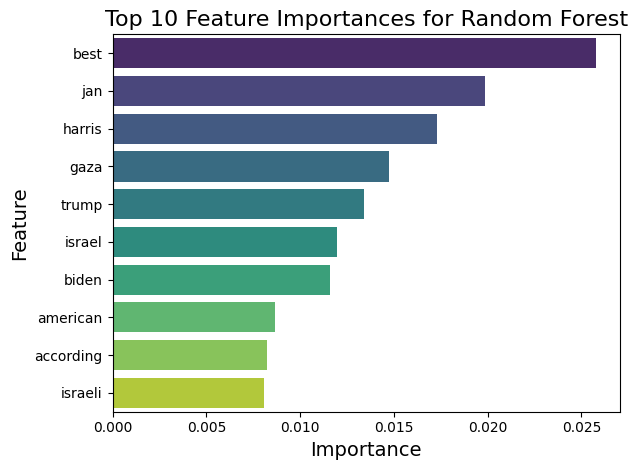

In [ ]:
# Feature importance analysis
feature_importances = rf_model.feature_importances_
important_features = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)


# Feature importance analysis
feature_importances = rf_model.feature_importances_
important_features = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)

top_features = important_features.head(10)

# Plot using seaborn
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances for Random Forest', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()